# 傅里叶变换

# 1. 傅里叶变换简介

① 我们生活在时间的世界中，早上7:00起来吃早饭，8:00去挤地铁，9:00开始上班。。。以时间为参照就是时域分析。

② 但是在频域中一切都是静止的！( 每天都吃早饭，每个工作日都挤地铁。。。频域更关心做这件事的频率是多少。)

参考文献：https://zhuanlan.zhihu.com/p/19763358

# 2. 傅里叶变换作用

① 高频：变化剧烈的灰度分量，例如边界礁石。

② 低频：变化缓慢的灰度分量，例如一片大海。

③ 高通滤波器：只保留高频，会使得图像细节增强。高频边界锐化了，增强了，细节更明显了。

④ 低通滤波器：只保留低频，会使得图像模糊。低频信息保留下来了，高频信息没了，图像边界会变得模糊了。

① opencv 中主要就是 cv2.dft() 执行傅里叶变换到频域中 和 cv2.idft() 执行逆傅里叶变换，输入图像需要先转换成 np.float32 格式。

② 得到的结果中频率为 0 的部分会在左上角，通常要转换到中心位置，可以通过 shift 变换来实现。

③ cv2.dft() 返回的结果是双通道的 ( 实部，虚部 )，通常还需要转换成图像格式才能展示(0,255)像素值。

# 3. 傅里叶变换

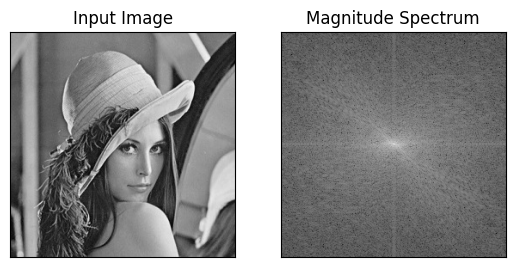

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# 【语法】cv2.imread(path, 0)
# 【作用】以灰度模式读取图片。傅里叶变换通常处理单通道数据
img = cv2.imread('01_Picture/13_Lena.jpg', 0)

# 【语法】np.float32(array)
# 【作用】将图像数据类型转换为 32 位浮点数。
# 【参数】cv2.dft 函数要求输入必须是浮点型，不能是标准的 uint8
img_float = np.float32(img) 

# 【语法】cv2.dft(src, flags)
# 【作用】执行离散傅里叶变换 (DFT)。
# 【参数】flags = cv2.DFT_COMPLEX_OUTPUT 表示输出结果包含“实部”和“虚部”两个通道
# 【维度】dft: (H, W, 2)。最后一个维度 2 分别存储实部和虚部
dft = cv2.dft(img_float, flags = cv2.DFT_COMPLEX_OUTPUT) 

# 【语法】np.fft.fftshift(array)
# 【作用】频谱移频。
# 【逻辑】默认 DFT 的零频率（低频）分量在左上角，此函数将其移动到图像中心，方便人类观察
dft_shift = np.fft.fftshift(dft) 

# 【语法】cv2.magnitude(x, y) 计算 sqrt(x^2 + y^2)
# 【作用】将复数结果（实部和虚部）转换为幅度（Magnitude），即该频率的强弱。
# 【数学处理】20 * np.log(...)：由于频率值的动态范围极大（中心点可能上百万，边缘可能很小），
# 直接显示是一片黑。通过对数变换压缩数值范围，映射到可见的灰度区间
magnitude_spectrum = 20 * np.log( 1+ cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]) ) 

# --- 可视化部分 ---
# 展示原图
plt.subplot(121), plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])

# 展示频谱图
# 越靠近中心的地方代表图像的低频部分（平滑区域）；越往外代表高频部分（边缘、噪声、细节）
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([]) 

plt.show()

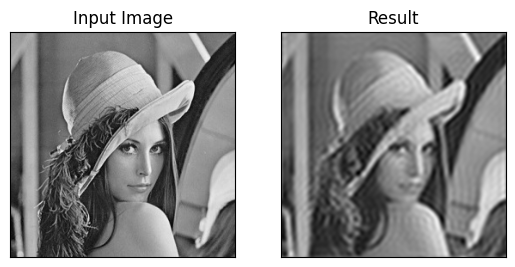

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# 【语法】cv2.imread(filename, flags)
# 【作用】读取图像。0 表示以灰度模式读取。
img = cv2.imread('01_Picture/13_Lena.jpg', 0)

# 【语法】np.float32(array)
# 【作用】将图像数据转换为 32 位浮点数。OpenCV 的 DFT 函数要求输入必须是浮点型。
img_float32 = np.float32(img)

# --- DFT (傅里叶变换) 阶段 ---

# 【语法】cv2.dft(src, flags)
# 【作用】执行离散傅里叶变换。flags=cv2.DFT_COMPLEX_OUTPUT 表示输出是一个双通道数组，分别代表实部和虚部。
dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)

# 【语法】np.fft.fftshift(array)
# 【作用】频谱移频。将零频率（低频）分量从图像的四个角移动到图像的正中心。
dft_shift = np.fft.fftshift(dft)

# --- 掩码 (Mask) 制作阶段 ---

# 【语法】rows, cols = img.shape
# 【作用】获取图像的高和宽，用于定位频谱中心。
rows, cols = img.shape
crow, ccol = int(rows/2), int(cols/2) 

# 【语法】np.zeros(shape, dtype)
# 【作用】创建一个全黑的掩码矩阵（全为 0）。形状为 (rows, cols, 2)，最后的 2 对应 DFT 的双通道。
mask = np.zeros((rows, cols, 2), np.uint8)

# 【语法】mask[y1:y2, x1:x2] = 1
# 【作用】在掩码中心开一个 60x60 的“窗口”，设为 1。这构成了低通滤波器：只允许中心附近的低频信号通过。
mask[crow-30:crow+30, ccol-30:ccol+30] = 1 

# --- IDFT (逆傅里叶变换) 阶段 ---

# 【语法】fshift = dft_shift * mask
# 【作用】频域滤波。将频谱图与掩码点乘，中心区域（乘1）被保留，四周高频区域（乘0）被抹除。
fshift = dft_shift * mask 

# 【语法】np.fft.ifftshift(array)
# 【作用】逆移频。将中心化的频谱重新还原到原始的“四个角”分布状态，为逆变换做准备。
f_ishift = np.fft.ifftshift(fshift) 

# 【语法】cv2.idft(src)
# 【作用】执行离散傅里叶逆变换。将频域信号转换回空域（图像空间）。
img_back = cv2.idft(f_ishift)

# 【语法】cv2.magnitude(x, y)
# 【作用】计算向量幅度 $\sqrt{Re^2 + Im^2}$。因为 IDFT 结果包含实部和虚部，需要计算模长来还原图像亮度。
img_back = cv2.magnitude(img_back[:,:,0], img_back[:,:,1]) 

# --- 显示阶段 ---

plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_back, cmap='gray')
plt.title('Result'), plt.xticks([]), plt.yticks([])
plt.show()

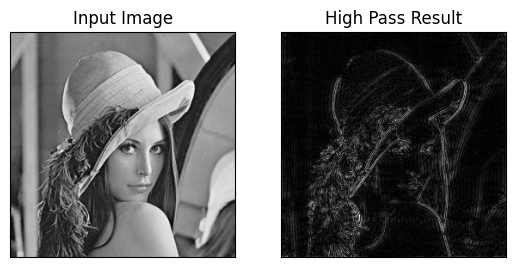

In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# 【语法】cv2.imread(path, flags)
# 【作用】读取图像。0 表示灰度模式，将图像载入为单通道矩阵。
img = cv2.imread('01_Picture/13_Lena.jpg', 0)

# 【语法】np.float32(data)
# 【作用】将数据转换为 32 位浮点型。OpenCV 的 DFT 计算需要高精度浮点数以保证复数运算的准确性。
img_float32 = np.float32(img)

# --- DFT (傅里叶变换) ---

# 【语法】cv2.dft(src, flags)
# 【作用】执行离散傅里叶变换。flags=cv2.DFT_COMPLEX_OUTPUT 输出包含“实部”和“虚部”的双通道结果。
dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)

# 【语法】np.fft.fftshift(array)
# 【作用】频谱移频。将频谱的零频率（直流分量/能量中心）从四个角移动到图像中心。
dft_shift = np.fft.fftshift(dft)

# --- 掩码 (Mask) 制作：高通滤波器 ---

rows, cols = img.shape
crow, ccol = int(rows/2), int(cols/2) # 计算频谱中心坐标

# 【语法】np.ones(shape, dtype)
# 【作用】创建一个全为 $1$ 的矩阵。形状与频谱一致（双通道），代表默认允许所有频率通过。
mask = np.ones((rows, cols, 2), np.uint8)

# 【语法】mask[y1:y2, x1:x2] = 0
# 【作用】核心操作：将频谱中心 60x60 的区域（即低频部分）强行抹除（置为 $0$）。
# 只有远离中心的高频信号（边缘和细节）能被保留。
mask[crow-30:crow+30, ccol-30:ccol+30] = 0 

# --- IDFT (逆傅里叶变换) ---

# 【语法】fshift = dft_shift * mask
# 【作用】频域滤波。将位移后的频谱与掩码相乘，实现“挖掉中心低频”的效果。
fshift = dft_shift * mask

# 【语法】np.fft.ifftshift(array)
# 【作用】逆移频。在逆变换前，必须将中心化的频谱重新推回四个角落，符合数学运算规律。
f_ishift = np.fft.ifftshift(fshift)

# 【语法】cv2.idft(src)
# 【作用】离散傅里叶逆变换。将处理后的频域信号还原回空域（图像空间）。
img_back = cv2.idft(f_ishift)

# 【语法】cv2.magnitude(x, y)
# 【作用】计算模长 $\sqrt{Re^2 + Im^2}$。将逆变换得到的复数结果转换为人类可观察的像素亮度值。
img_back = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])

# --- 结果展示 ---

plt.subplot(121), plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_back, cmap = 'gray')
# 结果图像会显得非常暗，只有轮廓清晰可见
plt.title('High Pass Result'), plt.xticks([]), plt.yticks([]) 
plt.show()